# Setup

In [67]:
# Read the data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Tokenization
from nltk.tokenize import sent_tokenize, word_tokenize, WhitespaceTokenizer
from nltk.probability import FreqDist

from pyarabic.araby import sentence_tokenize, tokenize, is_arabicrange

# Preprocessing
import re
from sklearn.preprocessing import LabelEncoder

# Splitting

from sklearn.model_selection import train_test_split



# Vectorization
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# Modeling
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score,recall_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# for reproducibility purposes
seed = 44

# Read Dialect Twittes Dataset

In [68]:
dfTw = pd.read_csv('dialect_dataset_with_twittes.csv')

dfTw.head()

,id,dialect,Twittes
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


## EDA

In [69]:
# Get some Information about our DataFrame.
dfTw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  int64 
 1   dialect  458197 non-null  object
 2   Twittes  458197 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.5+ MB


By observing the above data, we can conclude :
- id is int
- dialect/Twittes is object
- All the columns are non-null (no-empty or missing value).

In [70]:
# Another check Nulls for each column
dfTw.isnull().sum()

id         0
dialect    0
Twittes    0
dtype: int64

In [71]:
# Check the shape of our dataframe
dfTw.shape

(458197, 3)

In [72]:
# Check our dialects and their numbers
print(dfTw.dialect.unique(),'\n\n Number of Dialects >> ', dfTw.dialect.nunique())

['IQ' 'LY' 'QA' 'PL' 'SY' 'TN' 'JO' 'MA' 'SA' 'YE' 'DZ' 'EG' 'LB' 'KW'
 'OM' 'SD' 'AE' 'BH'] 

 Number of Dialects >>  18


In [73]:
# Check number of samples for each dialect
dfTw.dialect.value_counts()

EG    57636
PL    43742
KW    42109
LY    36499
QA    31069
JO    27921
LB    27617
SA    26832
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64

#### Notice : There is Unbalance in our dialects. :( 

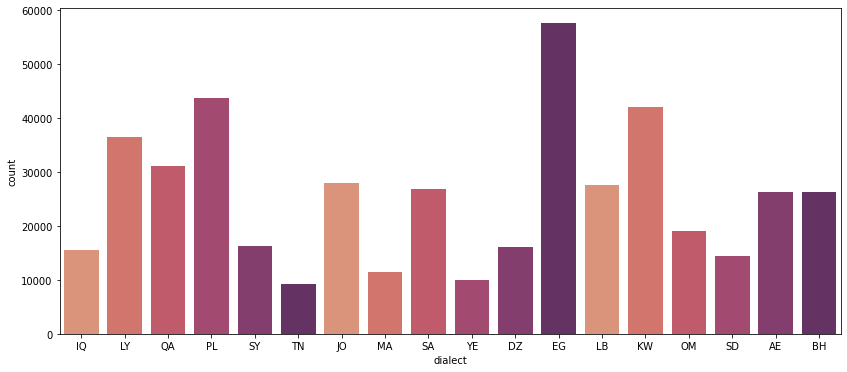

In [79]:
# Display Unbalanced data in dialects 
plt.figure(figsize = (14,6))
sns.countplot(x = dfTw.dialect, palette = sns.color_palette("flare"), data =dfTw)
plt.savefig('dialects.png')
plt.show()

In [75]:
# Check rows containing duplicate data
duplic_rows = dfTw[dfTw.duplicated()]

print('Number of duplicate rows: ', duplic_rows.shape)

Number of duplicate rows:  (0, 3)


##### No duplicate rows

# Pre-processing

In [10]:
# adapted from https://github.com/bakrianoo/aravec

# function to clean and normalize text 
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    text = re.sub('([@A-Za-z0-9_]+)|[^\w\s]', '', text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text

In [11]:
# Check the difference before - after cleaning
print(str(dfTw['Twittes'][0:1]))
print('\n----------------------------\n')
dfTw['Twittes'][0:1] = clean_text(str(dfTw['Twittes'][0:1]))
dfTw['Twittes'][0:1]

0    @Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
Name: Twittes, dtype: object

----------------------------



0    لكن بالنهايه  ينتفض  يغير
Name: Twittes, dtype: object

In [12]:
# Simple for-loop to feed twittes after cleaning to list
clean_twittes = []

for i in dfTw['Twittes'] :
    i = clean_text(str(i))
    clean_twittes.append(i)

In [13]:
clean_twittes[0:5]

['لكن بالنهايه  ينتفض  يغير',
 'يعني هذا محسوب علي البشر  حيونه وحشيه  وتطلبون من الغرب يحترمكم ويؤمن بدينكم ولاينعتكم بالارهاب',
 'مبين من كلامه خليجي',
 'يسلملي مرورك وروحك الحلوه',
 'وين هل الغيبه  اخ محمد']

In [14]:
# Append clean list to our DataFrame 
dfTw['twittes'] = clean_twittes
dfTw['twittes'].head()

0                            لكن بالنهايه  ينتفض  يغير
1    يعني هذا محسوب علي البشر  حيونه وحشيه  وتطلبون...
2                                  مبين من كلامه خليجي
3                            يسلملي مرورك وروحك الحلوه
4                               وين هل الغيبه  اخ محمد
Name: twittes, dtype: object

In [15]:
# Transform Dialects into numeric format as labels

le = LabelEncoder()
dfTw['dialect'] = le.fit_transform(dfTw['dialect'])

In [16]:
# Check unique labels 
dfTw.dialect.unique()

array([ 4,  8, 12, 11, 15, 16,  5,  9, 13, 17,  2,  3,  7,  6, 10, 14,  0,
        1])

## Tokenization with Word

In [17]:
dfTw['twittes'] = dfTw['twittes'].apply(lambda x : tokenize(str(x), conditions=is_arabicrange))
dfTw['twittes'].head()

0                         [لكن, بالنهايه, ينتفض, يغير]
1    [يعني, هذا, محسوب, علي, البشر, حيونه, وحشيه, و...
2                             [مبين, من, كلامه, خليجي]
3                       [يسلملي, مرورك, وروحك, الحلوه]
4                          [وين, هل, الغيبه, اخ, محمد]
Name: twittes, dtype: object

In [18]:
# Tokenization with Sentences.

# dfTw['twittes'] = dfTw['twittes'].apply(lambda x : sentence_tokenize(str(x)))
# dfTw['twittes'].head()

### Remove Stop Words

In [19]:
# stopWords = open("list.txt", encoding="utf8").read()

stopWords = set(stopwords.words('arabic'))


In [20]:
# Tokenize our Twittes 
words_ = tokenize(str(dfTw['twittes']), conditions=is_arabicrange)

# Check words are not in our stopWords
wordsFiltered = []
for w in words_:
    if w not in stopWords:
        wordsFiltered.append(w)

print(wordsFiltered)

['بالنهايه', 'ينتفض', 'يغير', 'يعني', 'محسوب', 'علي', 'البشر', 'حيونه', 'وحشيه', 'مبين', 'كلامه', 'خليجي', 'يسلملي', 'مرورك', 'وروحك', 'الحلوه', 'وين', 'الغيبه', 'اخ', 'محمد', 'مبسوطين', 'منك', 'اللي', 'باسطانا', 'والله', 'ماينده', 'ابش', 'يختي', 'شو', 'عملنا', 'حنا', 'تهربي', 'مننا', 'احنا', 'مساكين', 'الله', 'يبارك', 'وبالعافيه', 'السحله', 'ضيفي', 'بتطلع', 'سحليه']


In [21]:
# Check number of wordsFiltered vs. stopWords
print(len(wordsFiltered)) ; print(len(stopWords))

42
701


In [22]:
dfTw['twittes'] = dfTw['twittes'].apply(lambda x: [item for item in x if item not in stopWords])
dfTw['twittes'].head()

0                              [بالنهايه, ينتفض, يغير]
1    [يعني, محسوب, علي, البشر, حيونه, وحشيه, وتطلبو...
2                                 [مبين, كلامه, خليجي]
3                       [يسلملي, مرورك, وروحك, الحلوه]
4                              [وين, الغيبه, اخ, محمد]
Name: twittes, dtype: object

In [23]:
# Remove unclean Twittes Column from our DataFrame
dfTw.drop('Twittes', axis= 1, inplace= True)
dfTw.head()

,id,dialect,twittes
0,1175358310087892992,4,"[بالنهايه, ينتفض, يغير]"
1,1175416117793349632,4,"[يعني, محسوب, علي, البشر, حيونه, وحشيه, وتطلبو..."
2,1175450108898565888,4,"[مبين, كلامه, خليجي]"
3,1175471073770573824,4,"[يسلملي, مرورك, وروحك, الحلوه]"
4,1175496913145217024,4,"[وين, الغيبه, اخ, محمد]"


### Frequency Distributions

In [24]:
word_tokens = FreqDist(word for sent in dfTw["twittes"] for word in sent)

In [25]:
freq_dist = FreqDist(word_tokens)

print(freq_dist)

# OUTPUT:  Vocabulary -- Total Wards

<FreqDist with 455686 samples and 5099071 outcomes>


In [26]:
# Check frequent words based on FreqDist
frequent_words = []

for key, value in freq_dist.items():
    if value >= 1000:
        frequent_words.append(key.lower())
        
len(frequent_words)

515

In [27]:
frequent_words[:20]

['يعني',
 'علي',
 'وين',
 'محمد',
 'ياخي',
 'اذا',
 'المشكله',
 'الله',
 'عنك',
 'العرب',
 'ابو',
 'اللي',
 'خلص',
 'والله',
 'انا',
 'شيء',
 'معه',
 'بالعكس',
 'فيهم',
 'يمكن']

In [28]:
freq_dist.most_common(20)

[('اللي', 64183),
 ('علي', 56800),
 ('الله', 48396),
 ('انا', 35801),
 ('مش', 30527),
 ('والله', 25618),
 ('هه', 21310),
 ('ان', 19958),
 ('شي', 19552),
 ('انت', 18246),
 ('الي', 15202),
 ('او', 14474),
 ('يعني', 13825),
 ('عشان', 13341),
 ('الناس', 13297),
 ('اي', 13202),
 ('اذا', 13177),
 ('مو', 11883),
 ('حتي', 11755),
 ('انه', 11162)]

In [29]:
# Return the frequency of a given word in the range [0, 1]
freq_dist.freq('الله')

0.009491140641108939

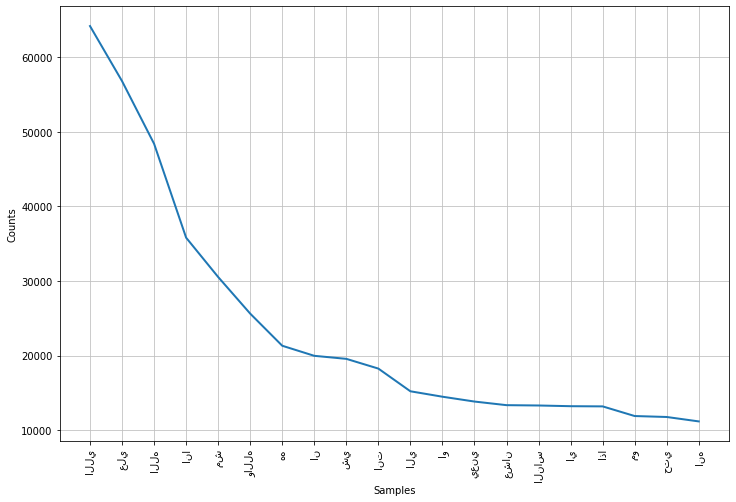

In [30]:
# Display 20 most common words
fig, ax = plt.subplots(figsize=(12, 8))

freq_dist.plot(20, cumulative=False)

plt.show()

# Modeling

In [35]:
# Function to simplify measuring.
def summarize_clf(y_test, pred):

    acc = accuracy_score(y_test, pred, normalize=True)
    num_acc = accuracy_score(y_test, pred, normalize=False)
    prec = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    
    print("Length of testing data: ", len(y_test))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("precision_score : " , prec)
    print("recall_score : ", recall)

In [40]:
# data after 
X = dfTw.twittes
y = dfTw.dialect

X = X.astype('str')

In [41]:
X.isnull().sum()

0

In [42]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state= seed)

In [43]:
X_train[:3]

114855    ['مش', 'الهندسه', 'الكليات', 'واغلب', 'الجامعا...
68134     ['ٱمسيت', 'ٱبيھہ', 'ۆ', 'قلبيے', 'لھہ', 'مشتٱق...
286379    ['نقول', 'علي', 'الغلط', 'ده', 'غلط', 'يبقي', ...
Name: twittes, dtype: object

## CountVectorizer

In [44]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words= stopWords)

In [45]:
# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train.values)

In [46]:
# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test.values)

In [47]:
# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

['ءء', 'ءاتها', 'ءاتيه', 'ءادم', 'ءالوجع', 'ءرءتو', 'ءلي', 'ءمن', 'ءناهه', 'ءه']


## TF-IDF Vectorizer

In [48]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words= stopWords, max_df= 0.7)

In [49]:
# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.values)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])


['ءء', 'ءاتها', 'ءاتيه', 'ءادم', 'ءالوجع', 'ءرءتو', 'ءلي', 'ءمن', 'ءناهه', 'ءه']


# Naive Bayes Models..
#### Train Multi Naive-Bayes Model With Count_train

## MultinomialNB

In [50]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

### With CountVectorizer data

In [51]:
# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)


0.487090790048014


In [52]:
summarize_clf(y_test, pred)

Length of testing data:  91640
accuracy_count :  44637
accuracy_score :  0.487090790048014
precision_score :  0.5819805926740711
recall_score :  0.487090790048014


In [54]:
# Hyperparamete Tuning (Alpha)

# Define train_and_predict()
def train_and_predict(alpha, X_train, X_test):
    # Instantiate the classifier
    model = MultinomialNB(alpha= alpha)
    # Fit to the training data
    model.fit(X_train, y_train)
    # Predict the labels: pred
    pred = model.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha, X_train= count_train, X_test= count_test))
    print()

Alpha:  0.0
Score:  0.4753491924923614

Alpha:  0.1
Score:  0.5370253164556962

Alpha:  0.2
Score:  0.5369707551287647

Alpha:  0.30000000000000004
Score:  0.5319838498472282

Alpha:  0.4
Score:  0.5245744216499345

Alpha:  0.5
Score:  0.5172522915757312

Alpha:  0.6000000000000001
Score:  0.5108577040593627

Alpha:  0.7000000000000001
Score:  0.504746835443038

Alpha:  0.8
Score:  0.4983085988651244

Alpha:  0.9
Score:  0.49256874727193367



We can see the best alpha is : **0.1 -> 53.7**

#### OneVsRest Multinomial Classifier

In [55]:
# Instantiate the model. 
ovr_nb_clf = OneVsRestClassifier(MultinomialNB())

In [56]:
ovr_nb_clf.fit(count_train, y_train)

# Create the predicted tags: pred
pred = ovr_nb_clf.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Display the summary of Classifier
summarize_clf(y_test, pred)

0.5040375381929288
Length of testing data:  91640
accuracy_count :  46190
accuracy_score :  0.5040375381929288
precision_score :  0.5872773174941887
recall_score :  0.5040375381929288


In [57]:
# Define train_and_predict()
def train_and_predict(alpha, X_train, X_test):
    # Instantiate the classifier
    model = OneVsRestClassifier(MultinomialNB(alpha= alpha))
    # Fit to the training data
    model.fit(X_train, y_train)
    # Predict the labels: pred
    pred = model.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha, X_train= count_train, X_test= count_test))
    print()

Alpha:  0.0
Score:  0.47494543867306854

Alpha:  0.1
Score:  0.5434526407682235

Alpha:  0.2
Score:  0.5438782191182889

Alpha:  0.30000000000000004
Score:  0.5397206460061109

Alpha:  0.4
Score:  0.5345264076822348

Alpha:  0.5
Score:  0.5297577477084243

Alpha:  0.6000000000000001
Score:  0.5234286337843737

Alpha:  0.7000000000000001
Score:  0.5180161501527717

Alpha:  0.8
Score:  0.5130074203404626

Alpha:  0.9
Score:  0.5087298123090354



Here we can see the best alpha changed to : **0.2 -> 54.38**

### With TF-IDF_train

In [59]:
# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.39799214316892184


In [60]:
# Display the summary of Classifier
summarize_clf(y_test, pred)

Length of testing data:  91640
accuracy_count :  36472
accuracy_score :  0.39799214316892184
precision_score :  0.6335307121324141
recall_score :  0.39799214316892184


In [61]:
# Define train_and_predict()
def train_and_predict(alpha, X_train, X_test):
    # Instantiate the classifier
    model = MultinomialNB(alpha= alpha)
    # Fit to the training data
    model.fit(X_train, y_train)
    # Predict the labels: pred
    pred = model.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha, X_train= tfidf_train, X_test= tfidf_test))
    print()

Alpha:  0.0
Score:  0.46377127891750325

Alpha:  0.1
Score:  0.5073330423395896

Alpha:  0.2
Score:  0.486348756001746

Alpha:  0.30000000000000004
Score:  0.4680379746835443

Alpha:  0.4
Score:  0.4524770842426888

Alpha:  0.5
Score:  0.4400043649061545

Alpha:  0.6000000000000001
Score:  0.4280554343081624

Alpha:  0.7000000000000001
Score:  0.4193910955914448

Alpha:  0.8
Score:  0.411239633347883

Alpha:  0.9
Score:  0.404190309908337



We can see the best alpha is : **0.1 -> 50.73**

### OneVsRest  

In [62]:
ovr_nb_clf.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = ovr_nb_clf.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Display the summary of Classifier
summarize_clf(y_test, pred)

0.4314818856394588
Length of testing data:  91640
accuracy_count :  39541
accuracy_score :  0.4314818856394588
precision_score :  0.62823549647778
recall_score :  0.4314818856394588


In [63]:
# Define train_and_predict()
def train_and_predict(alpha, X_train, X_test):
    # Instantiate the classifier
    model = OneVsRestClassifier(MultinomialNB(alpha= alpha))
    # Fit to the training data
    model.fit(X_train, y_train)
    # Predict the labels: pred
    pred = model.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha, X_train= tfidf_train, X_test= tfidf_test))
    print()

Alpha:  0.0
Score:  0.4598537756438237

Alpha:  0.1
Score:  0.5161065037101702

Alpha:  0.2
Score:  0.5018987341772152

Alpha:  0.30000000000000004
Score:  0.48864033173286775

Alpha:  0.4
Score:  0.4780226975120035

Alpha:  0.5
Score:  0.4676887821911829

Alpha:  0.6000000000000001
Score:  0.45877346137058056

Alpha:  0.7000000000000001
Score:  0.4505237887385421

Alpha:  0.8
Score:  0.4438018332605849

Alpha:  0.9
Score:  0.43753819292885204



Here we can see the best alpha changed to : **0.1 -> 51.61**

### Improving the Classifier :

- Tweaking alpha levels. **Done.**

- Trying a new classification model. **Down..**

- Training on a larger dataset.

- Improving text preprocessing.

#### Trying a new classification models..

In [64]:
# Instantiate a Stochastic Gradiant Model.
sgd_clf = SGDClassifier(random_state=seed, loss= 'hinge', penalty= 'l2')

In [65]:
# With Count_data

# Fit the classifier to the training data
sgd_clf.fit(count_train, y_train)

# Create the predicted tags: pred
pred = sgd_clf.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Display the summary of Classifier
summarize_clf(y_test, pred)

0.5082060235704933
Length of testing data:  91640
accuracy_count :  46572
accuracy_score :  0.5082060235704933
precision_score :  0.49397944788699305
recall_score :  0.5082060235704933


In [66]:
# With TF-IDF_data

# Fit the classifier to the training data
sgd_clf.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = sgd_clf.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Display the summary of Classifier
summarize_clf(y_test, pred)

0.4951331296377128
Length of testing data:  91640
accuracy_count :  45374
accuracy_score :  0.4951331296377128
precision_score :  0.4836247067713672
recall_score :  0.4951331296377128


# Summary 
After many testing with defferent Multiclass algorithms I can show the Multi-NB-OneOverRest is the best **Until Now...**